In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import warnings
warnings.filterwarnings("ignore")

# **Plan of Action**
1. Load the data.
2.  Get to know the data.
3.  Drop duplicates and null values.
4.  Extract year & month from the date data.
5.  Perform some analytics on the text data (text).
6.  Have a cleaned column of the text data; *cleaned*.
7.  Perform some analytics on the text data (cleaned).

### **Steps 1-5**

In [2]:
tweets = pd.read_csv('../data/tweets.csv')

In [3]:
tweets.sample(n=3, random_state=42)

,text,date
911,"Anybody can protest in front of Whitehouse, we...",2023-03-31 09:59:27+00:00
1183,https://t.co/DvRhUIZxtt\n\nStreet animals &amp...,2023-04-01 08:26:23+00:00
33,I try my absolute best to stay out of politics...,2023-04-03 10:35:01+00:00


In [4]:
tweets.shape

(4657, 2)

In [5]:
tweets.isna().sum()

text    0
date    0
dtype: int64

In [8]:
tweets.text.duplicated().sum()
# 89 duplicates in the text column, this is highly expected.

89

In [9]:
tweets_no_duplicates = tweets.copy()

In [19]:
tweets_no_duplicates[tweets_no_duplicates.text.duplicated()].index
# Duplicates index

Int64Index([ 224,  416,  651,  732,  910,  915, 1272, 1284, 1285, 1316, 1317,
            1343, 1490, 1491, 1518, 1575, 1580, 1609, 1666, 1728, 1737, 1827,
            1846, 1915, 1951, 1953, 2010, 2013, 2027, 2028, 2029, 2059, 2077,
            2078, 2137, 2145, 2154, 2160, 2163, 2205, 2210, 2284, 2318, 2356,
            2361, 2362, 2363, 2402, 2404, 2428, 2429, 2430, 2472, 2474, 2475,
            2476, 2481, 2482, 2483, 2484, 2600, 2602, 2621, 2894, 3039, 3062,
            3090, 3113, 3133, 3135, 3158, 3163, 3177, 3187, 3210, 3212, 3228,
            3257, 3258, 3281, 3319, 3382, 3461, 3505, 3583, 3649, 3653, 3657,
            4457],
           dtype='int64')

In [20]:
# Dropping duplicates
(tweets_no_duplicates.
drop(tweets_no_duplicates[tweets_no_duplicates.text.duplicated()].
index, inplace = True))

In [21]:
tweets_no_duplicates.text.duplicated().sum()

0

In [22]:
tweets_no_duplicates.shape

(4568, 2)

In [23]:
tweets_no_duplicates.describe()

,text,date
count,4568,4568
unique,4568,4070
top,"""Ah, yes. I just love waking up to the sweet a...",2023-04-03 11:30:00+00:00
freq,1,28


In [24]:
tweets_no_duplicates.dtypes

text    object
date    object
dtype: object

In [25]:
# Getting the length of the text 
raw_text_length = [len(length.split()) for length in tweets_no_duplicates.loc[:,'text']]

In [26]:
tweets_length = tweets_no_duplicates.copy()

In [27]:
tweets_length['raw_text_length'] = raw_text_length

In [29]:
tweets_length.sample(n=3, random_state=42)

,text,date,raw_text_length
1567,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20
253,“It’s Starmer trying to make the party safe ag...,2023-04-02 20:31:29+00:00,39


In [30]:
tweets_length.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4568 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             4568 non-null   object
 1   date             4568 non-null   object
 2   raw_text_length  4568 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 2.6 MB


In [31]:
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
tweets_memory = tweets_length.copy()
tweets_memory = memory_magment(tweets_memory)    

In [33]:
tweets_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4568 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             4568 non-null   object
 1   date             4568 non-null   object
 2   raw_text_length  4568 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 2.6 MB


In [34]:
tweets_memory.sample(n=3, random_state=42)

,text,date,raw_text_length
1567,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20
253,“It’s Starmer trying to make the party safe ag...,2023-04-02 20:31:29+00:00,39


### **Analytics-1 (raw-text)**

In [35]:
raw_text_eda = tweets_memory

In [36]:
raw_text_eda.columns

Index(['text', 'date', 'raw_text_length'], dtype='object')

In [39]:
# Extracting the dates
raw_text_eda['year'] = raw_text_eda.date.apply(lambda x: x.split('-')[0])
raw_text_eda['month'] = raw_text_eda.date.apply(lambda x: x.split('-')[1])

In [41]:
raw_text_eda.sample(n=3,random_state=42)

,text,date,raw_text_length,year,month
1567,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15,2023,03
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20,2023,04
253,“It’s Starmer trying to make the party safe ag...,2023-04-02 20:31:29+00:00,39,2023,04


In [43]:
raw_text_eda.describe(include='O')

,text,date,year,month
count,4568,4568,4568,4568
unique,4568,4070,1,2
top,"""Ah, yes. I just love waking up to the sweet a...",2023-04-03 11:30:00+00:00,2023,04
freq,1,28,4568,3214


- The only months in here are March & April.
- Only one year; 2023.

In [53]:
(raw_text_eda.groupby('month')[['raw_text_length']]
.agg([('Count','count'),('Max','max'),
('Min','min'), ("Mean",'mean'),
('Deviation','std'),('Skew','skew'),
("Median",'median')]).reset_index())

month raw_text_length                                               
                  Count Max Min       Mean  Deviation      Skew Median
0    03            1354  58   5  30.393648  10.700836 -0.074337   30.0
1    04            3214  61   1  26.040137  12.060046  0.300078   25.0

The following can be derived from the table above;

**MAX LENGTH**

- The maximum length of March is 58
- The maximum length of April is 61

**MEAN LENGTH**

- March has a mean length of 30
- April has a mean length of 26

**DEVIATION LENGTH**

- March has a deveiation from mean length of 10
- April has a deveiation from mean length of 12

**SKEWNESS**
- March is negatively skewed
- April is positively skewed
- Both skewness values are minimal and not so problematic.

In [45]:
nums = raw_text_eda[['raw_text_length']]

In [47]:
def outliers(data,col):
    Q_1 = np.quantile(data[col],0.25)
    Q_3 = np.quantile(data[col],0.75)
    IQR = Q_3 - Q_1 
    lower_bound = Q_1 - (1.5* IQR)
    upper_bound = Q_3 + (1.5* IQR)
    IQR_values = ((data[col] >= Q_1) & (data[col] <= Q_3)).sum()
    outliers_beyond_upper_bound = (data[col] > upper_bound).sum()
    outliers_below_lower_bound = (data[col]  < lower_bound).sum()
    print(f"IQR value for column {col} is: {IQR}")
    print(f"Q_1 value for column {col} is: {Q_1}")
    print(f"Q_3 value for column {col} is: {Q_3}")
    print(f"Lower bound value for column {col} is: {lower_bound}")
    print(f"Upper bound value for column {col} is: {upper_bound}")
    print(f"The number of values within the IQR for {col} is {IQR_values}")
    print(f"The number of outliers beyond the upper bound for {col} is {outliers_beyond_upper_bound}")
    print(f"The number of outliers below the lower bound for {col} is {outliers_below_lower_bound}\n")

In [50]:
raw_text_eda.head(2)

,text,date,raw_text_length,year,month
0,"""Ah, yes. I just love waking up to the sweet a...",2023-04-03 11:36:44+00:00,35,2023,04
1,When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...,2023-04-03 11:36:05+00:00,35,2023,04


In [76]:
sns.set_theme(style="whitegrid")

In [77]:
def dates():
    try:
        date = ['04','03']
        for index,val in enumerate(date):
            value = (raw_text_eda.month == val) # The boolean for months
            the_month = raw_text_eda.loc[value] # New dataframe based on months
            colors_list = ['royalblue',
                    'darkgreen'
                  ]
            # Making the box plot
            fig,ax = plt.subplots(1,2, figsize=(20,5))
            sns.boxplot(data=the_month,x='raw_text_length',ax=ax[0],color=colors_list[index])
            sns.boxenplot(data=the_month,x='raw_text_length',ax=ax[1],color=colors_list[index])
            ax[0].set_title(f"The box plot of raw_text_length for month {val} with raw_text_length",fontdict={'size':15})
            ax[1].set_title(f"The boxen plot of raw_text_length for month {val} with raw_text_length",fontdict={'size':15})
            plt.subplots_adjust(wspace=0.1)

            # The outliers
            the_month_outlier = the_month[['raw_text_length']]
            for i in the_month_outlier.columns:
                print(f"review_score: {val}")
                outliers(the_month_outlier, i)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_month.info(memory_usage='deep')

review_score: 04
IQR value for column raw_text_length is: 19.0
Q_1 value for column raw_text_length is: 16.0
Q_3 value for column raw_text_length is: 35.0
Lower bound value for column raw_text_length is: -12.5
Upper bound value for column raw_text_length is: 63.5
The number of values within the IQR for raw_text_length is 1662
The number of outliers beyond the upper bound for raw_text_length is 0
The number of outliers below the lower bound for raw_text_length is 0

review_score: 03
IQR value for column raw_text_length is: 15.75
Q_1 value for column raw_text_length is: 23.0
Q_3 value for column raw_text_length is: 38.75
Lower bound value for column raw_text_length is: -0.625
Upper bound value for column raw_text_length is: 62.375
The number of values within the IQR for raw_text_length is 687
The number of outliers beyond the upper bound for raw_text_length is 0
The number of outliers below the lower bound for raw_text_length is 0



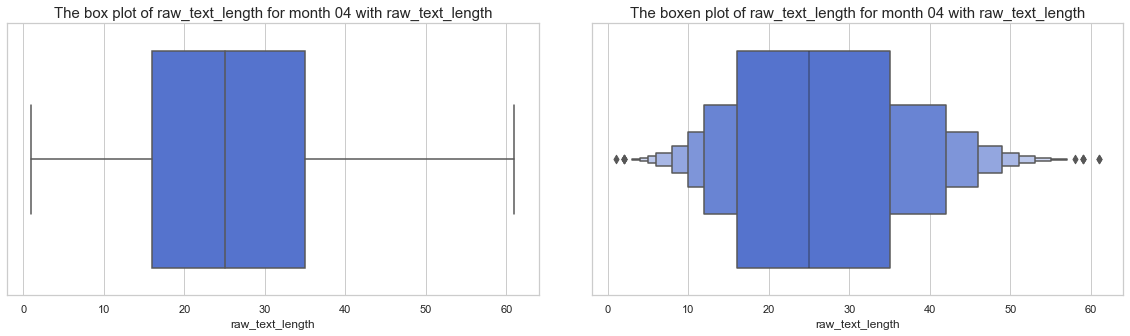

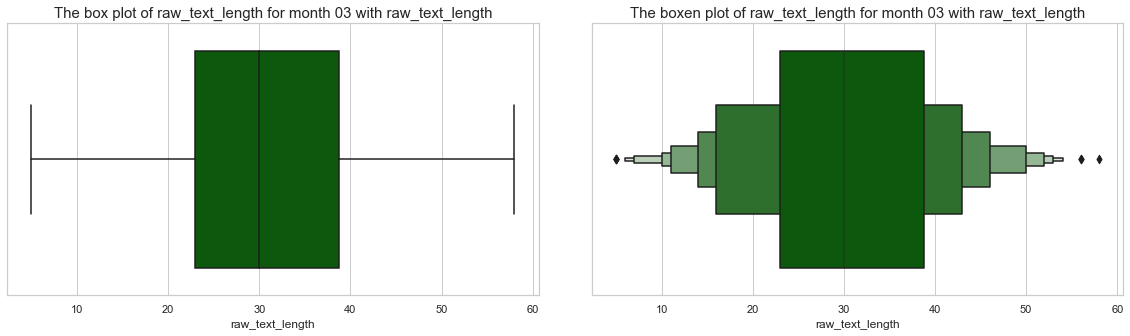

In [78]:
dates()

**Observations on raw text based off the box plots**

For the month of April;
- 25% of the data has text length that is below 16
- 75% of the data has text length that is below 35
- 25% of the data has a text length that is above 35
- IQR of the data is 19, i.e. 50% of the data is between 16 and 35.

For the month of March;
- 25% of the data has text length that is below 23
- 75% of the data has text length that is below 38.75
- 25% of the data has a text length that is above 38.75
- IQR of the data is 15.75, i.e. 50% of the data is between 23 and 38.75


In [79]:
def dates_hist_two():
    try:
        date = ['04','03']
        for index,val in enumerate(date):
            value = (raw_text_eda.month == val) # The boolean for months
            the_month = raw_text_eda.loc[value] # New dataframe based on months
            colors_list = ['royalblue',
                    'darkgreen'
                  ]
            # Making the hist plot
            fig,ax = plt.subplots(1, figsize=(20,5))
            sns.histplot(data=the_month,x='raw_text_length',kde=True, color=colors_list[index])
            fig.suptitle(f"The Histogram plot for month: {val} ",fontsize=15)
            ax.set_title(f"The raw_text_length skewness: {np.around(the_month['raw_text_length'].skew(axis=0),3)}",fontdict={'size':10})
            plt.subplots_adjust(wspace=0.2)
            # plt.subplots_adjust(hspace=0.5)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_month.info(memory_usage='deep')

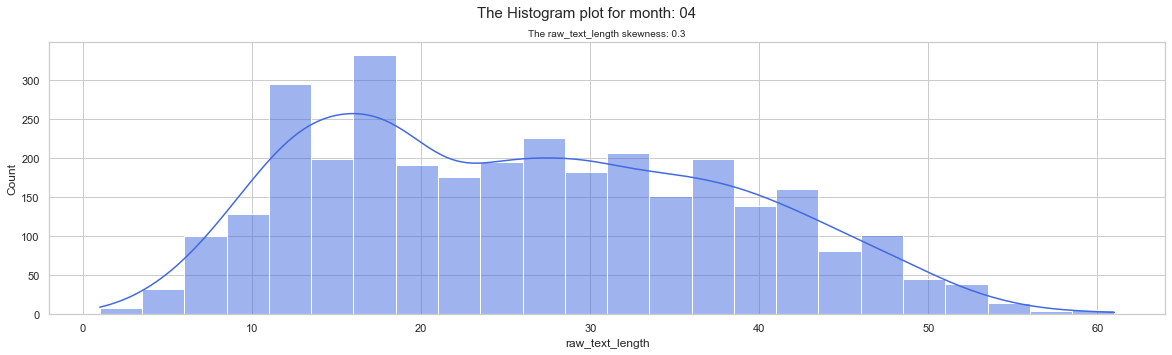

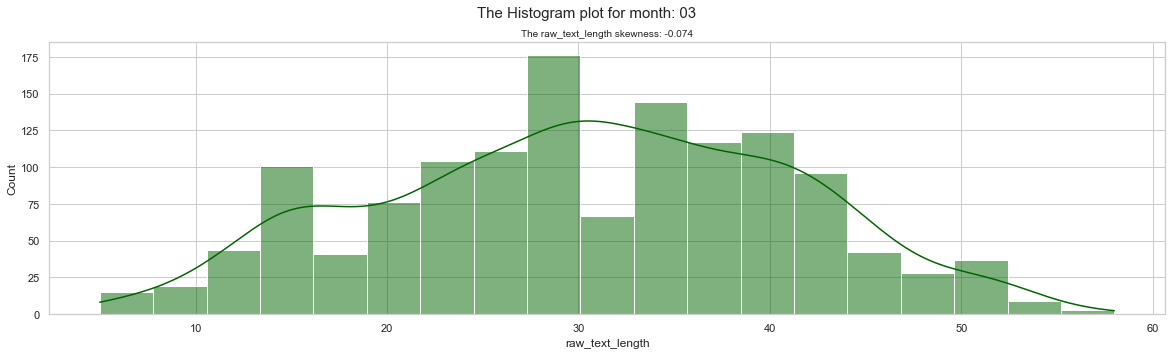

In [80]:
dates_hist_two()

### **Steps 6-7**

In [81]:
cleaned_text = raw_text_eda

In [82]:
cleaned_text.sample(n=3,random_state=3)

,text,date,raw_text_length,year,month
4628,Israel 🇮🇱 Full International Matches 1934-2023...,2023-04-03 11:18:04+00:00,21,2023,04
2236,100% OFF Udemy Coupon \nLearn complete Python ...,2023-03-31 04:32:09+00:00,26,2023,03
4441,I really like football and #Web3 so this is a ...,2023-04-03 11:22:06+00:00,27,2023,04


In [83]:
cleaned_text.loc[0,'text']

'"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm'

In [85]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Removing puntuactions
    # sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [86]:
cleaned_text['cleaned_text'] = cleaned_text["text"].apply(preprocess)

In [89]:
print(cleaned_text.loc[0,'text'],'\n')
print(cleaned_text.loc[0,'cleaned_text'])

"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It's like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm 

 ah yes just love waking up to the sweet aroma of political chaos and corruption in the morning it like breath of fresh air if that air was filled with hot garbage politics sarcasm


In [90]:
# Getting the length of the cleaned text 
cleaned_text_length = [len(length.split()) for length in cleaned_text.loc[:,'cleaned_text']]

cleaned_text['cleaned_text_length'] = cleaned_text_length

cleaned_text.sample(n=3, random_state=42)

,text,date,raw_text_length,year,month,cleaned_text,cleaned_text_length
1567,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15,2023,03,us sb real world ministry of truth being estab...,14
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20,2023,04,exclusive rep jeff van drew democrats afraid d...,17
253,“It’s Starmer trying to make the party safe ag...,2023-04-02 20:31:29+00:00,39,2023,04,it starmer trying to make the party safe agai...,37


### **Analytics-2 (cleaned-text)**

In [91]:
cleaned_text_eda = cleaned_text

In [92]:
cleaned_text_eda.columns

Index(['text', 'date', 'raw_text_length', 'year', 'month', 'cleaned_text',
       'cleaned_text_length'],
      dtype='object')

In [93]:
cleaned_text_eda.describe(include='O')

,text,date,year,month,cleaned_text
count,4568,4568,4568,4568,4568
unique,4568,4070,1,2,3900
top,"""Ah, yes. I just love waking up to the sweet a...",2023-04-03 11:30:00+00:00,2023,04,exclusive rep jeff van drew democrats afraid d...
freq,1,28,4568,3214,46


In [95]:
cleaned_text_eda.groupby('month')[['cleaned_text_length']].agg([('Count','count'),('Max','max'),('Min','min'), ("Mean",'mean'),('Deviation','std'),('Skew','skew'),("Median",'median')]).reset_index()

month cleaned_text_length                                               
                      Count Max Min       Mean  Deviation      Skew Median
0    03                1354  57   4  27.881832  10.525901  0.042902   28.0
1    04                3214  55   1  23.458307  11.755073  0.307749   23.0

The following can be derived from the table above (cleaned_text);

**MAX LENGTH**

- The maximum length of March is 57
- The maximum length of April is 55

**MEAN LENGTH**

- March has a mean length of 28
- April has a mean length of 24

**DEVIATION LENGTH**

- March has a deveiation from mean length of 11
- April has a deveiation from mean length of 12

**SKEWNESS**
- March is positively skewed
- April is positively skewed
- Both skewness values are minimal and not so problematic.

In [96]:
def dates_cleaned():
    try:
        date = ['04','03']
        for index,val in enumerate(date):
            value = (cleaned_text_eda.month == val) # The boolean for months
            the_month = cleaned_text_eda.loc[value] # New dataframe based on months
            colors_list = ['royalblue',
                    'darkgreen'
                  ]
            # Making the box plot
            fig,ax = plt.subplots(1,2, figsize=(20,5))
            sns.boxplot(data=the_month,x='cleaned_text_length',ax=ax[0],color=colors_list[index])
            sns.boxenplot(data=the_month,x='cleaned_text_length',ax=ax[1],color=colors_list[index])
            ax[0].set_title(f"The box plot of cleaned_text_length for month {val} with cleaned_text_length",fontdict={'size':15})
            ax[1].set_title(f"The boxen plot of cleaned_text_length for month {val} with cleaned_text_length",fontdict={'size':15})
            plt.subplots_adjust(wspace=0.1)

            # The outliers
            the_month_outlier = the_month[['cleaned_text_length']]
            for i in the_month_outlier.columns:
                print(f"review_score: {val}")
                outliers(the_month_outlier, i)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_month.info(memory_usage='deep')

In [97]:
def dates_hist_two_cleaned():
    try:
        date = ['04','03']
        for index,val in enumerate(date):
            value = (cleaned_text_eda.month == val) # The boolean for months
            the_month = cleaned_text_eda.loc[value] # New dataframe based on months
            colors_list = ['royalblue',
                    'darkgreen'
                  ]
            # Making the hist plot
            fig,ax = plt.subplots(1, figsize=(20,5))
            sns.histplot(data=the_month,x='cleaned_text_length',kde=True, color=colors_list[index])
            fig.suptitle(f"The Histogram plot for month: {val} ",fontsize=15)
            ax.set_title(f"The cleaned_text_length skewness: {np.around(the_month['cleaned_text_length'].skew(axis=0),3)}",fontdict={'size':10})
            plt.subplots_adjust(wspace=0.2)
            # plt.subplots_adjust(hspace=0.5)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_month.info(memory_usage='deep')

review_score: 04
IQR value for column cleaned_text_length is: 20.0
Q_1 value for column cleaned_text_length is: 13.0
Q_3 value for column cleaned_text_length is: 33.0
Lower bound value for column cleaned_text_length is: -17.0
Upper bound value for column cleaned_text_length is: 63.0
The number of values within the IQR for cleaned_text_length is 1747
The number of outliers beyond the upper bound for cleaned_text_length is 0
The number of outliers below the lower bound for cleaned_text_length is 0

review_score: 03
IQR value for column cleaned_text_length is: 16.0
Q_1 value for column cleaned_text_length is: 20.0
Q_3 value for column cleaned_text_length is: 36.0
Lower bound value for column cleaned_text_length is: -4.0
Upper bound value for column cleaned_text_length is: 60.0
The number of values within the IQR for cleaned_text_length is 733
The number of outliers beyond the upper bound for cleaned_text_length is 0
The number of outliers below the lower bound for cleaned_text_length is 0

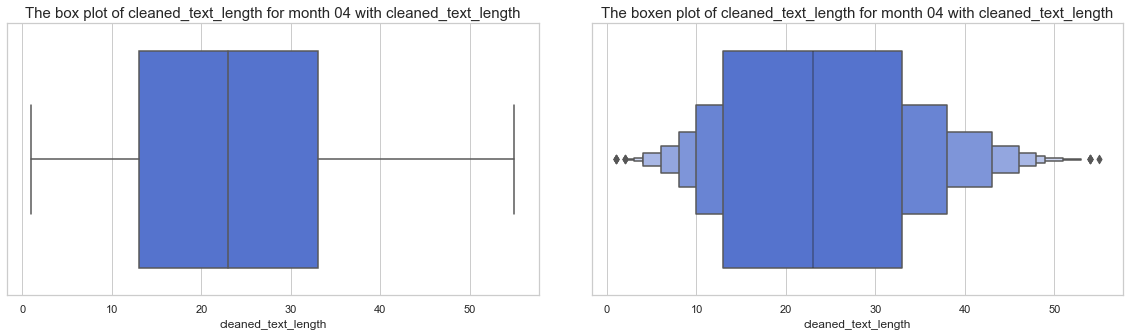

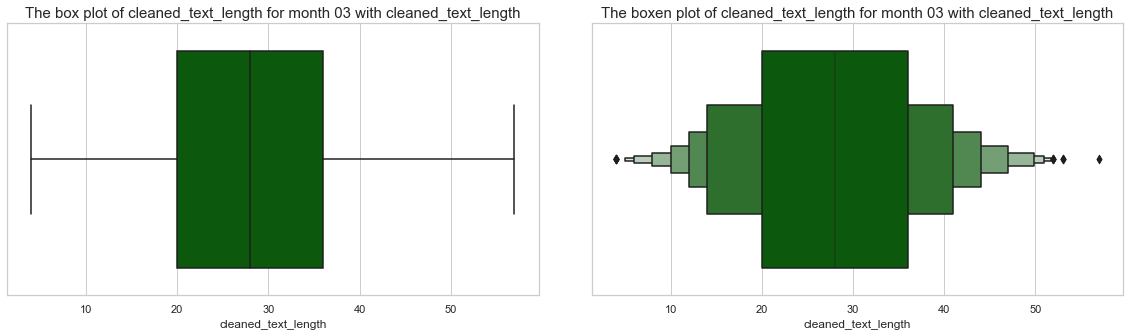

In [98]:
dates_cleaned()

**Observations on cleaned text based off the box plots**

For the month of April;
- 25% of the data has text length that is below 13
- 75% of the data has text length that is below 33
- 25% of the data has a text length that is above 33
- IQR of the data is 20, i.e. 50% of the data is between 13 and 33.

For the month of March;
- 25% of the data has text length that is below 20
- 75% of the data has text length that is below 36
- 25% of the data has a text length that is above 36
- IQR of the data is 16, i.e. 50% of the data is between 20 and 36


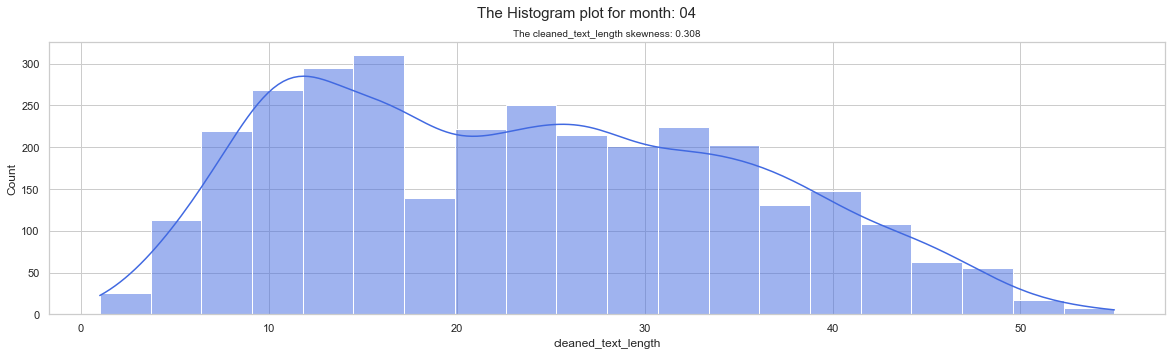

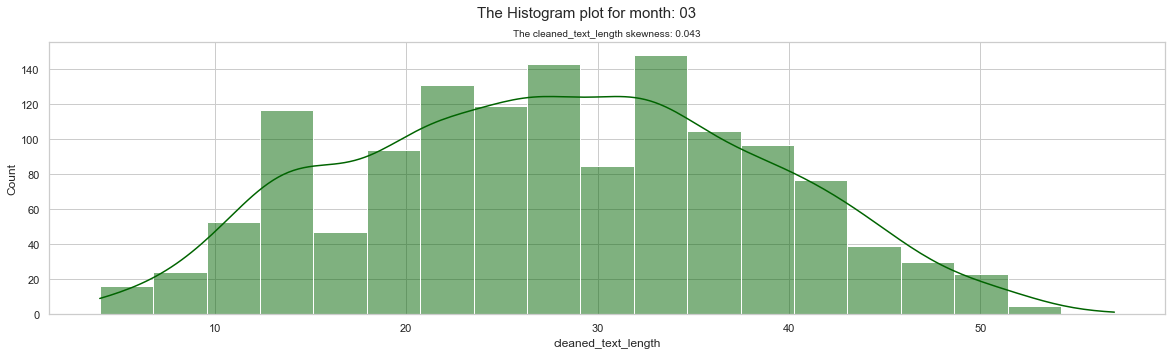

In [99]:
dates_hist_two_cleaned()

In [100]:
# Exporting the cleaned_text_eda
cleaned_text_eda.to_csv("../model/topic_data.csv",index=False)